In [1]:
# analytics
import pandas as pd 
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
#spatial 
import osmnx as ox
import geopandas as gpd
import contextily as cx
# plotting 
import seaborn as sns
import matplotlib.pyplot as plt
#settings
import warnings

In [2]:
# suppress deprication warnings
warnings.filterwarnings('ignore') 
# plot settings
sns.set_style('darkgrid')
sns.set_palette('rocket')


In [3]:
# load 2023 data set
path = '2023/fema_national_household_survey_2023_data_and_codebook.xlsx'
df = pd.read_excel(path, sheet_name='Coastal Flooding', header=1)

In [4]:
df.shape

(507, 126)

<span style='color:orange'>
Let's select the important variables, rename and recode
<span>

In [5]:
variables = ['id','state','zipcode','geographic_division','census_region','county','cfld_awareness','cfld_perception','cfld_exp',
             'cfld_floodzone','cfld_prepactions_a','cfld_prepactions_b','cfld_prepactions_c','cfld_prepactions_d','cfld_prepactions_e',
             'cfld_prepactions_f','cfld_prepactions_g','cfld_prepactions_h','cfld_prepactions_i','cfld_prepactions_j','cfld_prepactions_k',
             'cfld_prepactions_l','cfld_prepactions_m','cfld_prepactions_n','age','sex','education','education_original','ethnicity',
             'homeownership','income','income_original','rentmortgage']
sub_df = df[variables]

In [6]:
# Let's rename these variables
sub_df = sub_df.rename(columns= {
    'cfld_prepactions_a': 'supplies',
    'cfld_prepactions_b': 'insured',
    'cfld_prepactions_c': 'involved',
    'cfld_prepactions_d': 'learned_routes',
    'cfld_prepactions_e': 'made_plan',
    'cfld_prepactions_f': 'made_safer',
    'cfld_prepactions_g': 'planned_neighbors',
    'cfld_prepactions_h': 'practiced_drills',
    'cfld_prepactions_i': 'documents',
    'cfld_prepactions_j': 'rainy_day',
    'cfld_prepactions_k': 'alerts',
    'cfld_prepactions_l': 'family_communication',
    'cfld_prepactions_m': 'none',
    'cfld_prepactions_n': 'dont_know'
})
sub_df = sub_df.rename(columns={
    'cfld_awareness': 'awareness',
    'cfld_perception': 'perception',
    'cfld_exp': 'experience',
    'cfld_floodzone': 'floodzone'
})

In [7]:
sub_df.head()

id         state  zipcode geographic_division census_region        county  \
0   1    Washington    98033             Pacific          West          King   
1   2       Florida    33950      South Atlantic         South     Charlotte   
2   3    New Jersey     7031     Middle Atlantic     Northeast        Bergen   
3   4  Pennsylvania    19115     Middle Atlantic     Northeast  Philadelphia   
4   5  Pennsylvania    19148     Middle Atlantic     Northeast  Philadelphia   

    awareness   perception  experience floodzone  ...   dont_know    age  \
0          No  Very likely          No        No  ...       Blank  20-29   
1         Yes       Likely         Yes       Yes  ...       Blank  50-59   
2          No       Likely         Yes        No  ...       Blank  30-39   
3  Don't know   Don't know  Don't know        No  ...  Don't know  40-49   
4          No       Likely         Yes        No  ...       Blank  30-39   

      sex                                         education  \
0    Male                                 Bachelor's degree   
1  Female  Post graduate work/degree or professional degree   
2  Female                     High school degree or diploma   
3  Female                     High school degree or diploma   
4    Male                                 Bachelor's degree   

                                 education_original            ethnicity  \
0                                 Bachelor's degree  Non-Hispanic/Latino   
1  Post graduate work/degree or professional degree  Non-Hispanic/Latino   
2                     High school degree or diploma      Hispanic/Latino   
3                     High school degree or diploma  Non-Hispanic/Latino   
4                                 Bachelor's degree  Non-Hispanic/Latino   

  homeownership                income       income_original      rentmortgage  
0           Own    $75,000 to $99,999    $75,000 to $99,999   $1,001 - $1,500  
1           Own  $150,000 to $199,999  $150,000 to $199,999  More than $3,000  
2          Rent    $35,000 to $49,999    $35,000 to $49,999   $1,001 - $1,500  
3          Rent    $50,000 to $74,999    $50,000 to $74,999        Don't know  
4           Own  $100,000 to $149,999  $100,000 to $149,999   $1,001 - $1,500  

[5 rows x 33 columns]

In [8]:
print((sub_df.income_original != sub_df.income).any())
(sub_df.education_original != sub_df.education).any()

True


True

Variables are different. Leave in for now 

<span style='color:orange'>
Let's have a first look at the data 
<span>

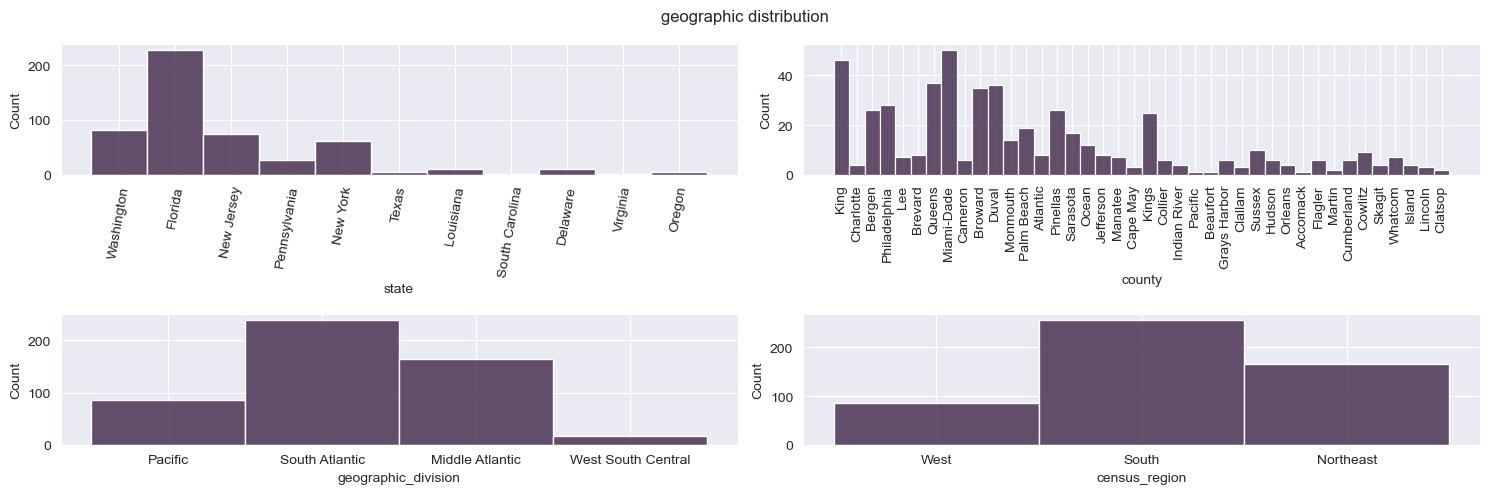

In [9]:
fig, ax = plt.subplots(2,2, figsize=(15,5))

sns.histplot(sub_df.state, ax = ax[0,0])
sns.histplot(sub_df.county, ax = ax[0,1])
sns.histplot(sub_df.geographic_division, ax = ax[1,0])
sns.histplot(sub_df.census_region, ax = ax[1,1])

#adjust individual x label rotations for readability
ax[0,0].tick_params(axis='x', rotation = 80)
ax[0,1].tick_params(axis='x', rotation=90)
plt.suptitle('geographic distribution')
plt.tight_layout() 

<span style="color:lightgreen">
findings: 

- only respondents in flood regions are included

- most respondents from florida 
- pacific underrepresnted compared to atlantic
<span>




<span style="color:orange">
to understand spatial distribution of respondents (and other variables, we will have to add shapefiles)

let's look into response variables first
<span>

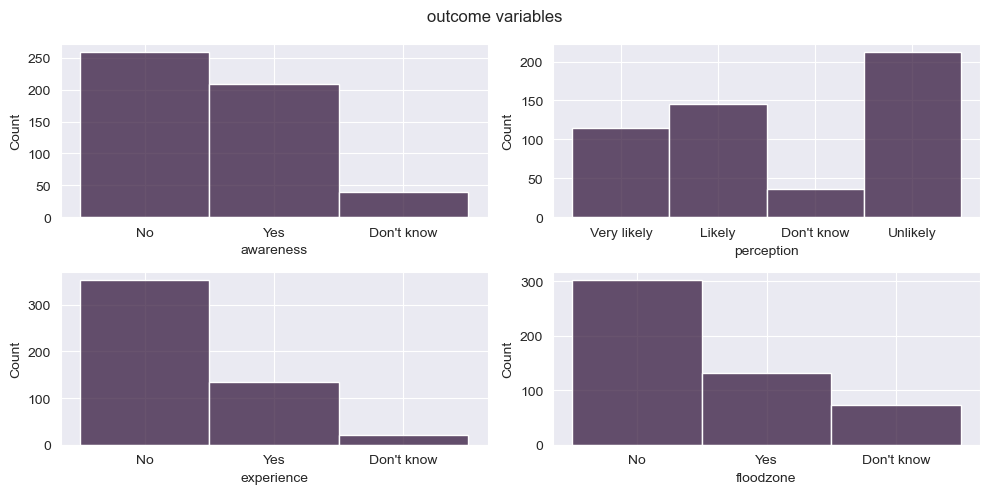

In [10]:
fig, ax = plt.subplots(2,2, figsize=(10,5))

sns.histplot(sub_df.awareness, ax = ax[0,0])
sns.histplot(sub_df.perception, ax = ax[0,1])
sns.histplot(sub_df.experience, ax = ax[1,0])
sns.histplot(sub_df.floodzone, ax = ax[1,1])

plt.suptitle('outcome variables')
plt.tight_layout() # avoid overlap of labels

<span style='color:lightgreen'>
findings: 

- ca 60% respondents do not live in a flood zone. That can in part be bc not every flood area is mapped by FEMA yet
- ca 20% has experienced flood before
- cfld_perception gives rich data distribution

- don't know is a small number. Can we maybe leave them out? 

<span style= 'color:orange'>
Let's change the variable coding and dtypes to numeric
<span>

In [11]:
sub_df.perception.replace({"Unlikely":0, "Likely":1, "Very likely":2, "Don't know": np.nan}, inplace = True)
sub_df.ethnicity.replace({'Non-Hispanic/Latino':0,'Hispanic/Latino': np.nan}, inplace = True)
sub_df.sex.replace({"Male":0, "Female":1, 'Third-Gender/Other': np.nan}, inplace = True)
sub_df.homeownership.replace({'Rent':0, 'Own':1}, inplace = True)

In [12]:
variables = ['awareness','experience','floodzone'] # for no, yes, Don't know
sub_df[variables] = sub_df[variables].replace({"No":0,"Yes":1, "Don't know": np.nan})

In [13]:
# adjust lower and upper tail ends to US income distribution
dict = {'Less than $10,000':10000,
        '$10,000 to $14,999':12500,
        '$15,000 to $24,999':20000,
        '$25,000 to $34,999':30000,
        '$35,000 to $49,999':47500,
        '$50,000 to $74,999':62500,
        '$75,000 to $99,999':87500,
        '$100,000 to $149,999':125000,
        '$150,000 to $199,999':175000,
        '$200,000 or more':290000
        }
sub_df.income.replace(dict, inplace = True);

value for highest income bracket is representing median income in that bracket:

https://www.census.gov/programs-surveys/cps.html

https://www.census.gov/library/publications/2022/demo/p60-276.html

In [14]:
# adjust upper tail to US age distribution 
dict = {'18-19': 18.5,
        '20-29': 25,
        '30-39': 35,
        '40-49': 45,
        '50-59': 55,
        '60-69': 65,
        '70-79': 75,
        '80+': 90
}
sub_df.age.replace(dict, inplace = True);

In [15]:
dict={'Less than high school diploma':0,
      'High school degree or diploma':1,
      'Some college, no degree':2,
      "Associate's degree":3, 
      "Bachelor's degree":4, 
      'Post graduate work/degree or professional degree':5
      }
sub_df.education.replace(dict, inplace = True)

In [16]:
# come up with something better for "more than 3000" adn "don't know" 
dict={'$0' : 0,
      '$1 - $500':250,
      '$501 - $750':675,
      '$751 - $1,000':875,
      '$1,001 - $1,500':1250,
      '$1,501 - $2,000':1750,
      '$2,001 - $2,500':2250,
      '$2,501 - $3,000':2750,
      'More than $3,000':3000,
      "Don't know": np.nan
      }
sub_df.rentmortgage.replace(dict, inplace = True)

In [17]:
sub_df.supplies.replace({'Blank': 0, 'Assembled or updated supplies': 1}, inplace=True)
sub_df.insured.replace({'Blank': 0, 'Documented and insured property': 1}, inplace=True)
sub_df.involved.replace({'Blank': 0, 'Got involved in my community': 1}, inplace=True)
sub_df.learned_routes.replace({'Blank': 0, 'Learned my evacuation routes': 1}, inplace=True)
sub_df.made_plan.replace({'Blank': 0, 'Made a plan': 1}, inplace=True)
sub_df.made_safer.replace({'Blank': 0, 'Made my home safer': 1}, inplace=True)
sub_df.planned_neighbors.replace({'Blank': 0, 'Planned with neighbors': 1}, inplace=True)
sub_df.practiced_drills.replace({'Blank': 0, 'Practiced emergency drills or habits': 1}, inplace=True)
sub_df.documents.replace({'Blank': 0, 'Safeguarded documents': 1}, inplace=True)
sub_df.rainy_day.replace({'Blank': 0, 'Saved for a rainy day': 1}, inplace=True)
sub_df.alerts.replace({'Blank': 0, 'Signed up for alerts and warnings': 1}, inplace=True)
sub_df.family_communication.replace({'Blank': 0, 'Tested family communication plan': 1}, inplace=True)
sub_df.none.replace({'Blank': 0, 'None of the above': 1}, inplace=True)
sub_df.dont_know.replace({'Blank': 0, "Don't know": 1}, inplace=True)

# let's also code as integer
variables = ['supplies','insured', 'involved', 'learned_routes', 'made_plan', 
             'made_safer', 'planned_neighbors', 'practiced_drills', 'documents', 
             'rainy_day', 'alerts','family_communication', 'none', 'dont_know']
sub_df[variables] = sub_df[variables].astype(int)

In [18]:
# lets recode zipcodes as string and fill up leading zeros that have gone missing 
sub_df.zipcode = sub_df.zipcode.astype('string')

for i in sub_df.index: 
    if len(sub_df.at[i,'zipcode']) == 4: 
        sub_df.at[i,'zipcode'] = str(0) + sub_df.at[i,'zipcode']
    if len(sub_df.at[i,'zipcode']) <= 4:
        print(i)
# classic lets try shit and pray loop... Make sure we fetched all exceptions...

<Axes: >

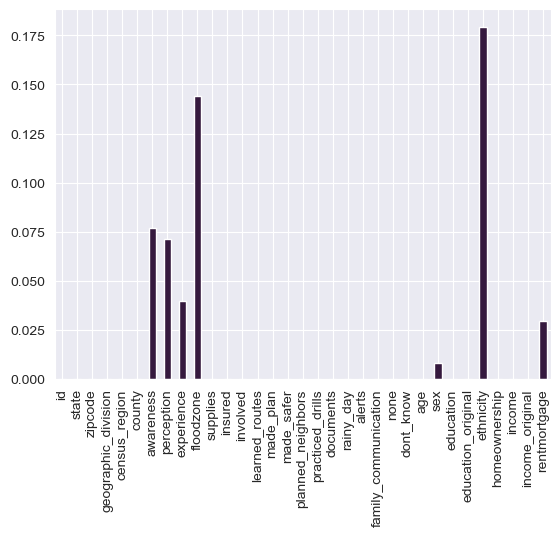

In [19]:
# let's see how many variables we have lost due to np.nan coding
sub_df.isna().mean().plot(kind='bar')

In [20]:
#Let's drop ethnicity
sub_df.drop(columns=['ethnicity'], inplace=True)

In [21]:
# let's see how many floodzones have np.nan where we find values for the same zipcode
non_null_floodzone = (
    sub_df.groupby('zipcode')['floodzone']
      .transform(lambda x: x.notna().any())
) # returns true if there a value for the same zipcode exists somewhere in sub_df 
sub_df['check'] = sub_df['floodzone'].isna() & non_null_floodzone 
(sub_df['check'] == True).sum() #how many values can we fill in manually like this? 

42

In [22]:
def fill_if_unique(grp):
    non_null_values = grp.dropna().unique()
    if len(non_null_values) == 1:
        # Only one unique floodzone in this group => fill all NaNs with it
        return grp.fillna(non_null_values[0])
    else:
        # Either no non-null values or multiple different ones => leave as is
        return grp

sub_df['floodzone'] = sub_df.groupby('zipcode')['floodzone'].transform(fill_if_unique)


### Double check this code block above!

In [23]:
sub_df.dropna(inplace=True) 

In [24]:
sub_df.shape # lost ca 100 obs (20%)

(409, 33)

<span style='color:orange'>
Let's have a look at adaptation measures

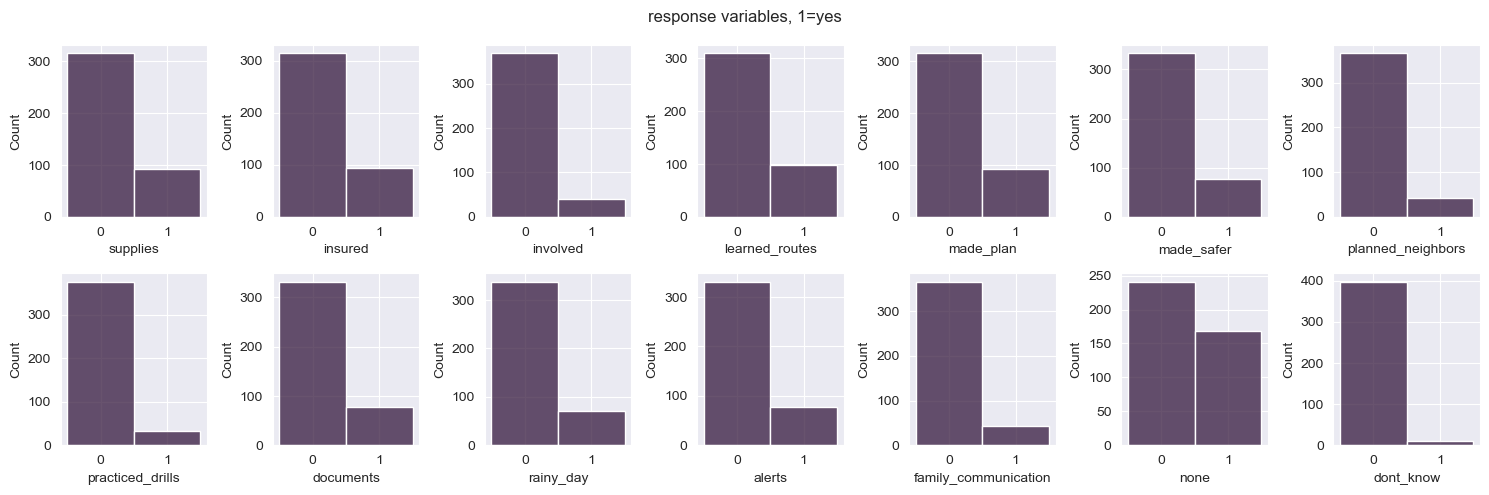

In [25]:
fig, ax = plt.subplots(2,7, figsize=(15,5))
ax = ax.flatten()
for idx, var in enumerate(variables): 
    sns.histplot(sub_df[var], ax = ax[idx], discrete=True)
plt.suptitle('response variables, 1=yes')
plt.tight_layout()

<span style = 'color: lightgreen'>
findings: 

- 40% of respondents have implemented nothing

- almost all adaptation options are implemented equally often. 
<span>


<span style = 'color: orange'>
Let's look at some correlations
<span>


<Axes: >

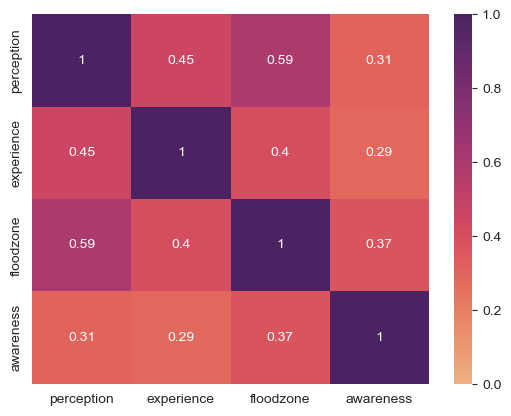

In [26]:
variables = ['perception', 'experience', 'floodzone', 'awareness']
sns.heatmap(sub_df[variables].corr(), cmap = 'flare', vmin=0, vmax=1, annot=True)

In [27]:
NumFloodzone = len(sub_df[sub_df.floodzone == 1]) # number of respondents living in floodzones
NumNoFloodzone = len(sub_df[sub_df.floodzone == 0])
NumExp = len(sub_df[sub_df.experience == 1]) # number of respondents with flood experience
NumFloodzoneExp = len(sub_df[(sub_df.floodzone == 1) & (sub_df.experience == 1)]) # number of respondents who live in floodzones and have flood experience
NumNoFloodzoneExp = len(sub_df[(sub_df.floodzone == 0) & (sub_df.experience == 1)])
share = NumFloodzoneExp/NumFloodzone * 100
print('share of respondents in flood zones who have experiecned flood =',share, '%')
shareNoFloodzone = NumNoFloodzoneExp / NumNoFloodzone * 100
print('share of respondents who have experienced flood outside a floodzone=', shareNoFloodzone,'%')

share of respondents in flood zones who have experiecned flood = 56.34920634920635 %
share of respondents who have experienced flood outside a floodzone= 16.607773851590103 %


<span style = 'color:lightgreen'>
findings: 


- all possible predictors correlate at least a bit

- floodzone and perception correlate strongly
- experience and perception correlate even less than floodzone and perception (42%)
- one explanation: experience and floodzone correlate at 28% -> low correlations with floodzones stem from the fact that 15% of flood experiences were recorded outside a floodzone
<span>

<span style = 'color:orange'>


<Axes: >

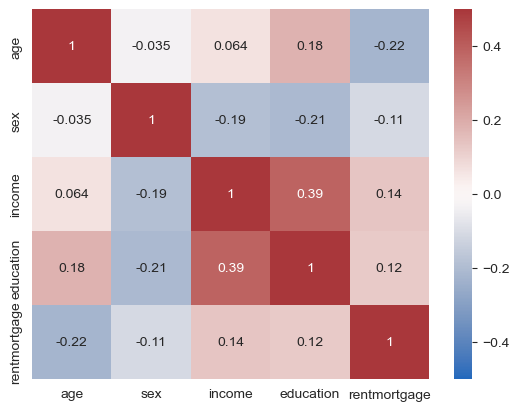

In [28]:
variables = ['age', 'sex', 'income', 'education', 'rentmortgage']
sns.heatmap(sub_df[variables].corr(), cmap='vlag', vmin=-0.5, vmax=0.5, annot = True) # note that effect directions are taken out for purpose of color mapping

<span style= 'color:lightgreen'>
findings: 

- correlation among covariates are small 

- notably, low correlation between age and income

- note relation between (education, rentmortgage) and age

- variables are nominal, correlation mathematically incorrect. 

<span style= 'color:orange'>
Let's map relationships between covariates and responses


In [29]:
variables = ['perception', 'experience', 'floodzone', 'awareness']
index = ['age', 'sex', 'income', 'rentmortgage', 'education']
age = [np.corrcoef(sub_df.age, sub_df[var])[0,1] for var in variables]
sex = [np.corrcoef(sub_df.sex, sub_df[var])[0,1] for var in variables]
income = [np.corrcoef(sub_df.income, sub_df[var])[0,1] for var in variables]
rentmortgage = [np.corrcoef(sub_df.rentmortgage, sub_df[var])[0,1] for var in variables]
education = [np.corrcoef(sub_df.education, sub_df[var])[0,1] for var in variables]

cor_df = pd.DataFrame([age, sex, income, rentmortgage, education] , index = index, columns = variables)
cor_df

perception  experience  floodzone  awareness
age            -0.333249   -0.222537  -0.280105  -0.110425
sex             0.061166   -0.012350   0.040734   0.036849
income         -0.067950   -0.037643  -0.059853  -0.045128
rentmortgage    0.074225    0.162144   0.081080   0.162202
education      -0.051301   -0.015511  -0.041769  -0.015274

Text(0.5, 1.0, 'correlations')

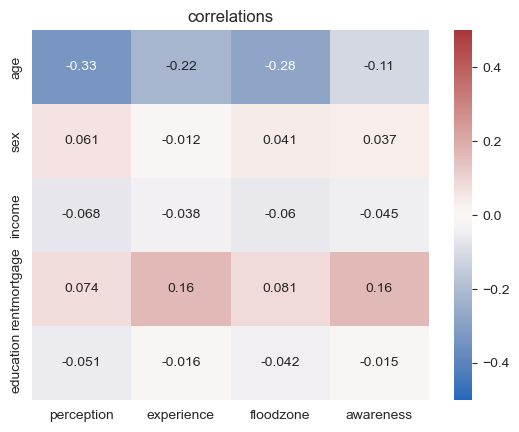

In [30]:
fig, ax = plt.subplots()
fig = sns.heatmap(cor_df, cmap='vlag', vmin=-0.5, vmax=0.5, annot=True)
plt.title('correlations')

<span style='color:lightgreen'>
findings: 

- older respondents are expecting less flooding
- older respondents are less likely to have experienced floodings??? 

<span style = 'color:orange'>
Let's have a look at correlations between outcome variables
<span>

<Axes: >

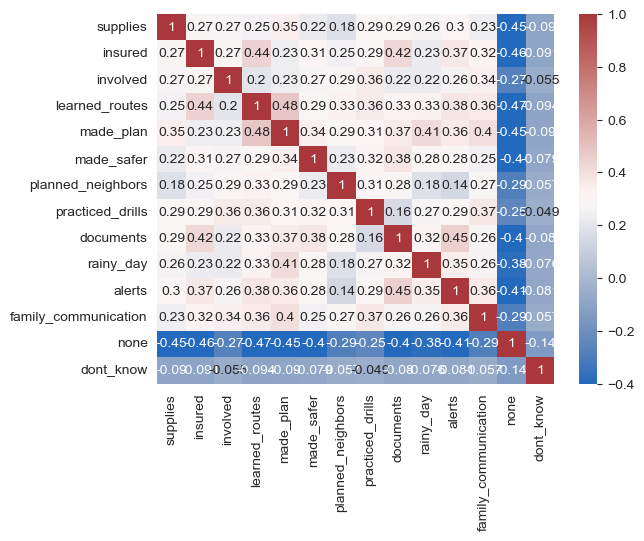

In [31]:
variables = ['supplies', 'insured', 'involved', 'learned_routes', 'made_plan',
             'made_safer', 'planned_neighbors', 'practiced_drills', 'documents', 'rainy_day',
             'alerts', 'family_communication', 'none', 'dont_know']
sns.heatmap(sub_df[variables].corr(),cmap='vlag', vmin=-0.4, vmax=1, annot=True)

<span style= 'color:lightgreen'>
findings: 

- all of the above correlate in same range: no specific links between specific types of adaptation 
- learned_routs and insured correlate stronger
- documents and insured correlate stronger
- alerts and insured correlate stronger
- made_plan and learned_routes correlate stronger

- alerts and documents correlate stronger

#### <span style='color:orange'>Let's start with spatial mapping<span>

In [32]:
path = '/Users/philip/Documents/ESE/ESE thesis/flood regression/shapefiles/tl_2024_us_zcta520.shp'
shp_gdf = gpd.read_file(path)
shp_gdf.head()

ZCTA5CE20 GEOID20       GEOIDFQ20 CLASSFP20 MTFCC20 FUNCSTAT20  ALAND20  \
0     47236   47236  860Z200US47236        B5   G6350          S  1029063   
1     47870   47870  860Z200US47870        B5   G6350          S     8830   
2     47851   47851  860Z200US47851        B5   G6350          S    53326   
3     47337   47337  860Z200US47337        B5   G6350          S   303089   
4     47435   47435  860Z200US47435        B5   G6350          S    13302   

   AWATER20   INTPTLAT20    INTPTLON20  \
0         0  +39.1517426  -085.7252769   
1         0  +39.3701518  -087.4735141   
2         0  +39.5735839  -087.2459559   
3         0  +39.8027537  -085.4372850   
4         0  +39.2657557  -086.2951577   

                                            geometry  
0  POLYGON ((-85.7341 39.15597, -85.72794 39.1561...  
1  POLYGON ((-87.47414 39.37016, -87.47409 39.370...  
2  POLYGON ((-87.24769 39.5745, -87.24711 39.5744...  
3  POLYGON ((-85.44357 39.80328, -85.44346 39.803...  
4  POLYGON ((-86.29592 39.26547, -86.29592 39.266...

In [33]:
(shp_gdf.ZCTA5CE20 != shp_gdf.GEOID20).any() #perfect duplicates

False

In [34]:
shp_gdf = shp_gdf.drop(columns=['ZCTA5CE20','GEOIDFQ20','CLASSFP20','MTFCC20','FUNCSTAT20','ALAND20','AWATER20','INTPTLAT20','INTPTLON20'])

In [35]:
# lets merge it baby
shp_gdf= shp_gdf.rename(columns={'GEOID20':'zipcode'})
gdf = sub_df.merge(shp_gdf, on = 'zipcode', how = 'left')
gdf = gpd.GeoDataFrame(gdf, geometry = gdf.geometry)
gdf.head()

id         state zipcode geographic_division census_region        county  \
0   1    Washington   98033             Pacific          West          King   
1   2       Florida   33950      South Atlantic         South     Charlotte   
2   3    New Jersey   07031     Middle Atlantic     Northeast        Bergen   
3   5  Pennsylvania   19148     Middle Atlantic     Northeast  Philadelphia   
4   8      New York   11691     Middle Atlantic     Northeast        Queens   

   awareness  perception  experience  floodzone  ...   age  sex  education  \
0        0.0         2.0         0.0        0.0  ...  25.0  0.0          4   
1        1.0         1.0         1.0        1.0  ...  55.0  1.0          5   
2        0.0         1.0         1.0        0.0  ...  35.0  1.0          1   
3        0.0         1.0         1.0        0.0  ...  35.0  0.0          4   
4        1.0         2.0         1.0        1.0  ...  35.0  0.0          3   

                                 education_original  homeownership  income  \
0                                 Bachelor's degree              1   87500   
1  Post graduate work/degree or professional degree              1  175000   
2                     High school degree or diploma              0   47500   
3                                 Bachelor's degree              1  125000   
4                                Associate's degree              1   62500   

        income_original  rentmortgage  check  \
0    $75,000 to $99,999        1250.0  False   
1  $150,000 to $199,999        3000.0  False   
2    $35,000 to $49,999        1250.0  False   
3  $100,000 to $149,999        1250.0  False   
4    $50,000 to $74,999        1750.0  False   

                                            geometry  
0  POLYGON ((-122.24342 47.68952, -122.23526 47.6...  
1  POLYGON ((-82.09962 26.91135, -82.09949 26.912...  
2  POLYGON ((-74.14753 40.78649, -74.14746 40.786...  
3  POLYGON ((-75.17492 39.8986, -75.17486 39.8989...  
4  POLYGON ((-73.78926 40.59651, -73.78925 40.596...  

[5 rows x 34 columns]

In [36]:
# adjust crs to cx requirements (Web Mercator)
gdf = gdf.to_crs(epsg=3857)  
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

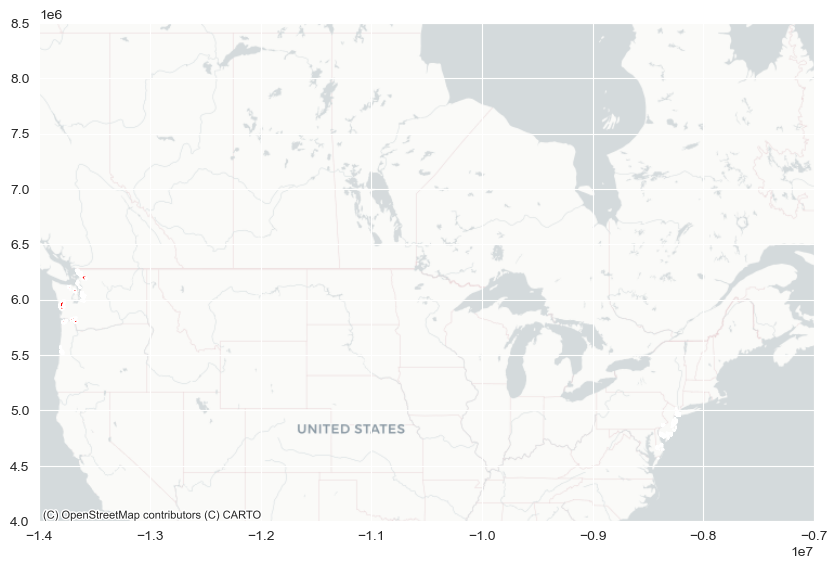

In [37]:
us_bounds = (-14000000, 4000000, -7000000, 8500000)  

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, color='red', alpha=1, markersize=30)
ax.set_xlim(us_bounds[0], us_bounds[2])  # Longitude limits
ax.set_ylim(us_bounds[1], us_bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.savefig('figures/us_map.png')

<span style = 'color:orange'>
Let's drill down further into the northeast and south west areas 
<span>

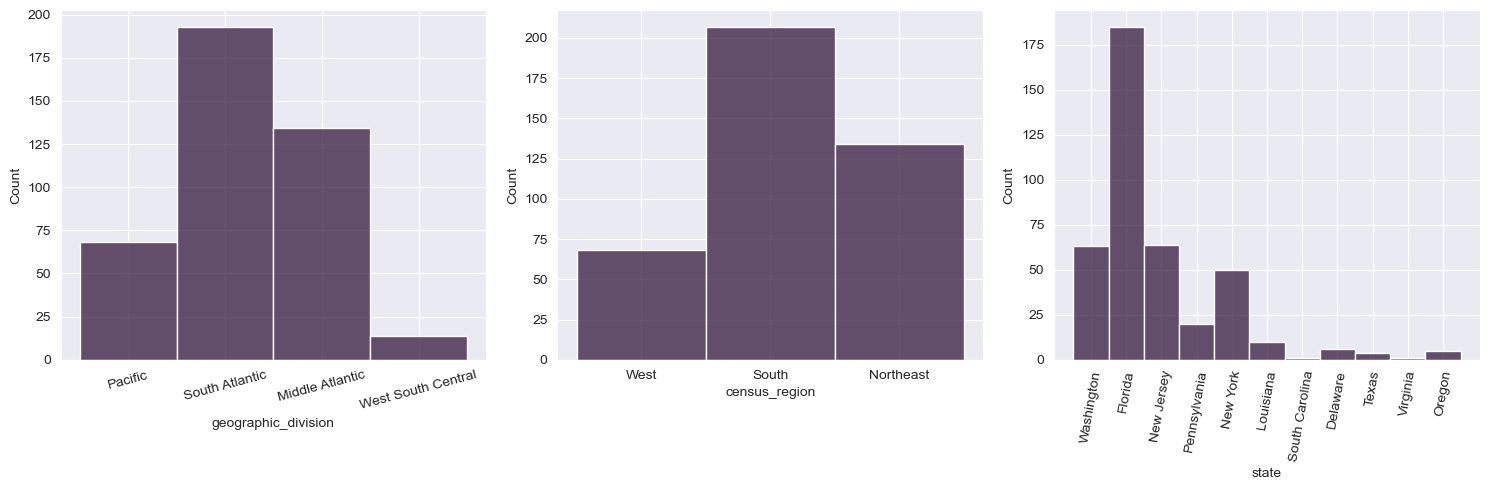

In [38]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.histplot(gdf.geographic_division, ax = ax[0])
sns.histplot(gdf.census_region, ax = ax[1])
sns.histplot(gdf.state, ax = ax[2])
ax[0].tick_params(axis='x', rotation = 15)
ax[2].tick_params(axis='x', rotation = 80)
plt.tight_layout()

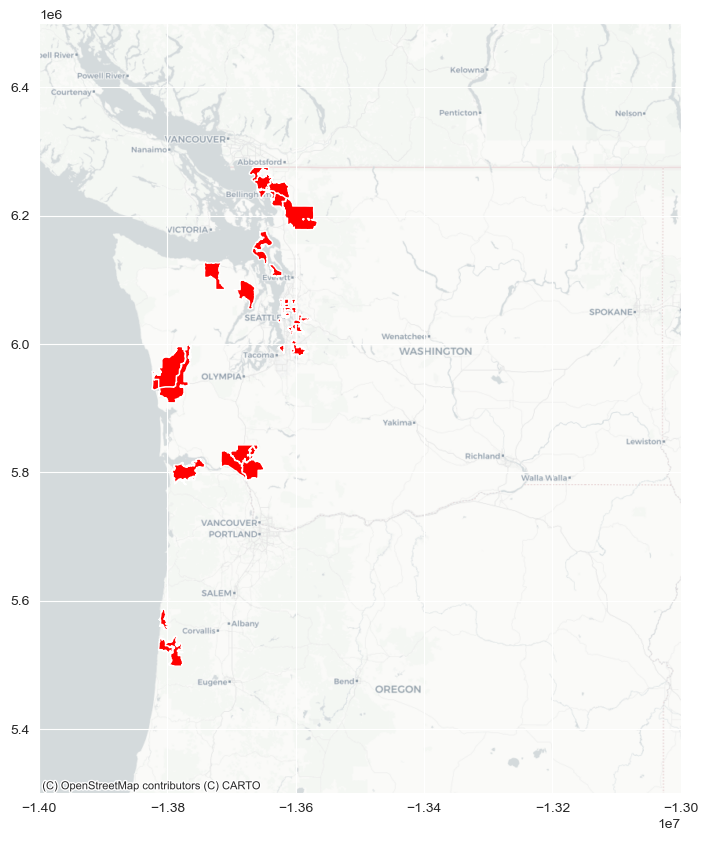

In [39]:
west_bounds = (-14000000, 5300000, -13000000, 6500000)

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, color='red', alpha=1, markersize=300)
ax.set_xlim(west_bounds[0], west_bounds[2])  # Longitude limits
ax.set_ylim(west_bounds[1], west_bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.savefig('figures/west_map.png')

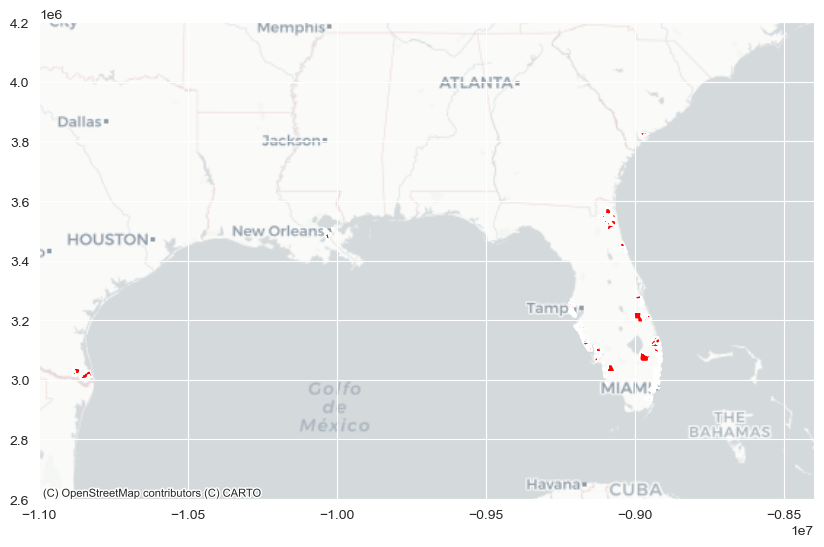

In [40]:
south_bounds = (-11000000, 2600000,  -8400000, 4200000)

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, color='red', alpha=1, markersize=300)
ax.set_xlim(south_bounds[0], south_bounds[2])  # Longitude limits
ax.set_ylim(south_bounds[1], south_bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.savefig('figures/south_map.png')

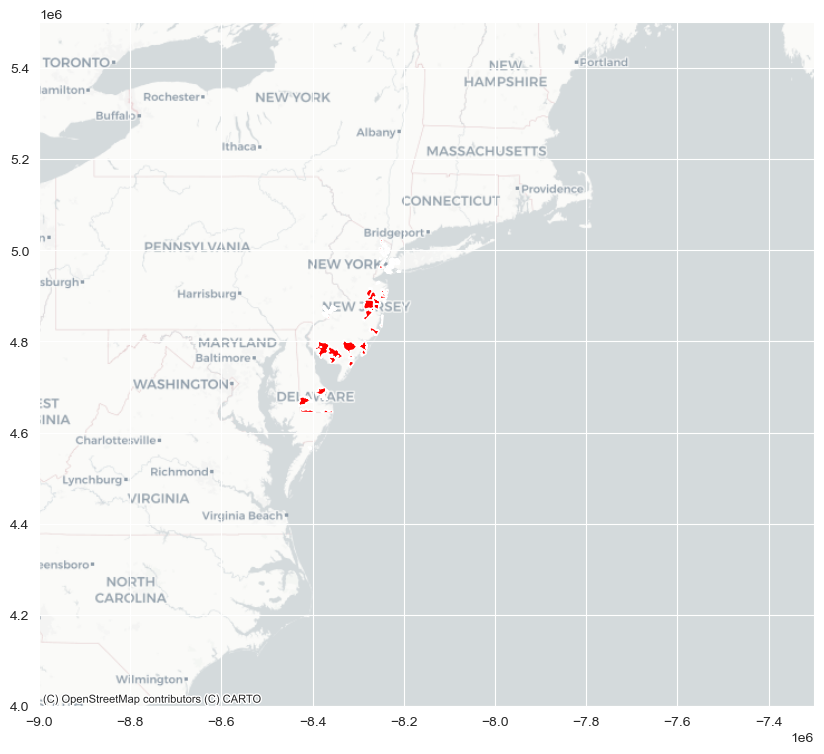

In [41]:
northeast_bounds = (-9000000, 4000000, -7300000, 5500000)

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, color='red', alpha=1, markersize=300)
ax.set_xlim(northeast_bounds[0], northeast_bounds[2])  # Longitude limits
ax.set_ylim(northeast_bounds[1], northeast_bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.savefig('figures/northeast_map.png')

<span style= 'color:lightgreen'>
findings: 

- Many flood regions (California & mid-East Coast) have no responses in the 2023 data
- focus regions will be washington/ oregon, florida, new jersey/ pennsylvania/ delaware/ virginia


<span style= 'color:orange'>
to do: 

- check response distribution against other years
- drill down into zipcode density per region
- investigate spatial distribution of density of responses

In [42]:
seattle = gdf[((gdf.state == 'Washington') | (gdf.state == 'Oregon'))]
florida = gdf[((gdf.state == 'Florida') | (gdf.state == 'Texas') | (gdf.state == 'Louisiana') | (gdf.state == 'South Carolina'))]
newjersey = gdf[(gdf.state == 'New Jersey') | (gdf.state == 'Pennsylvania') | (gdf.state == 'Delaware') | (gdf.state == 'Virginia') | (gdf.state == 'New York')]

In [43]:
zip_counts = sub_df.groupby(by='zipcode').size()
zip_counts = pd.DataFrame(zip_counts, columns=['density'])
zip_gdf = gdf.merge(zip_counts, on = 'zipcode', how='left')

<span style = 'color:orange'>
Let's plot the count of zipcodes onto the focus maps 

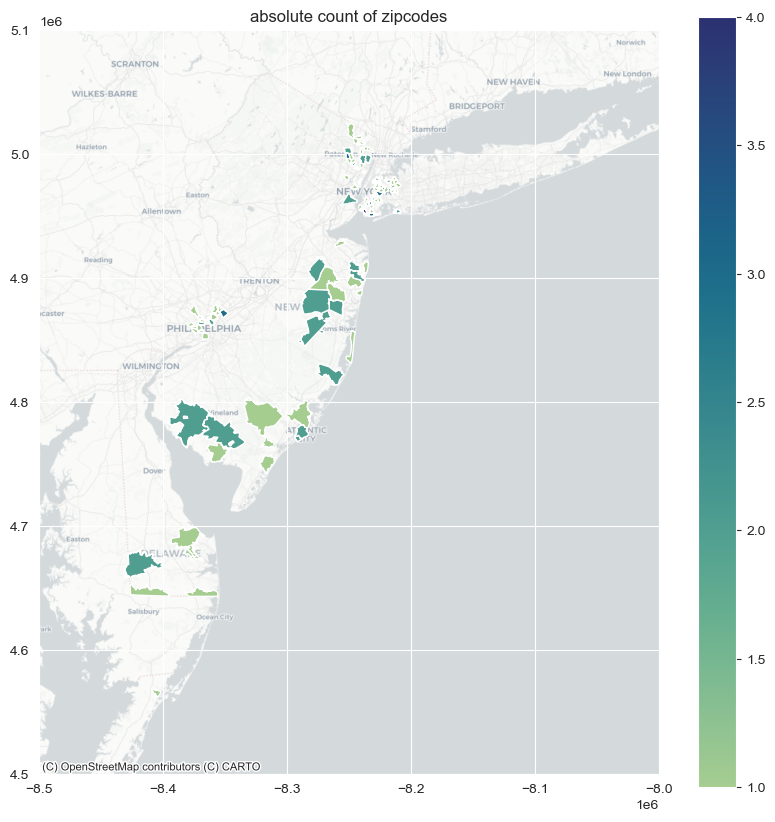

In [44]:
# new jersey
bounds = (-8500000, 4500000, -8000000, 5100000)

fig, ax = plt.subplots(figsize=(10,10))
zip_gdf.plot(ax=ax, cmap='crest', alpha=1, column='density', legend=True)
ax.set_xlim(bounds[0], bounds[2])  # Longitude limits
ax.set_ylim(bounds[1], bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title('absolute count of zipcodes')
plt.savefig('figures/density/newjersey_zips_density.png')

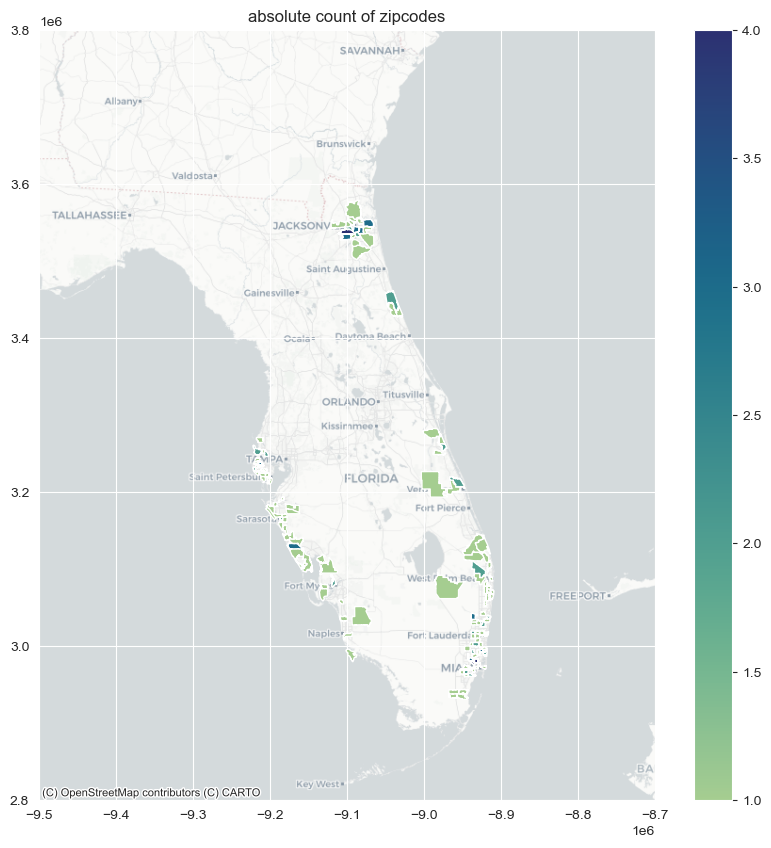

In [45]:
# florida
bounds = (-9500000, 2800000,  -8700000, 3800000)

fig, ax = plt.subplots(figsize=(10,10))
zip_gdf.plot(ax=ax, cmap='crest', alpha=1, column='density', legend=True)
ax.set_xlim(bounds[0], bounds[2])  # Longitude limits
ax.set_ylim(bounds[1], bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title('absolute count of zipcodes')
plt.savefig('figures/density/florida_zips_density.png')

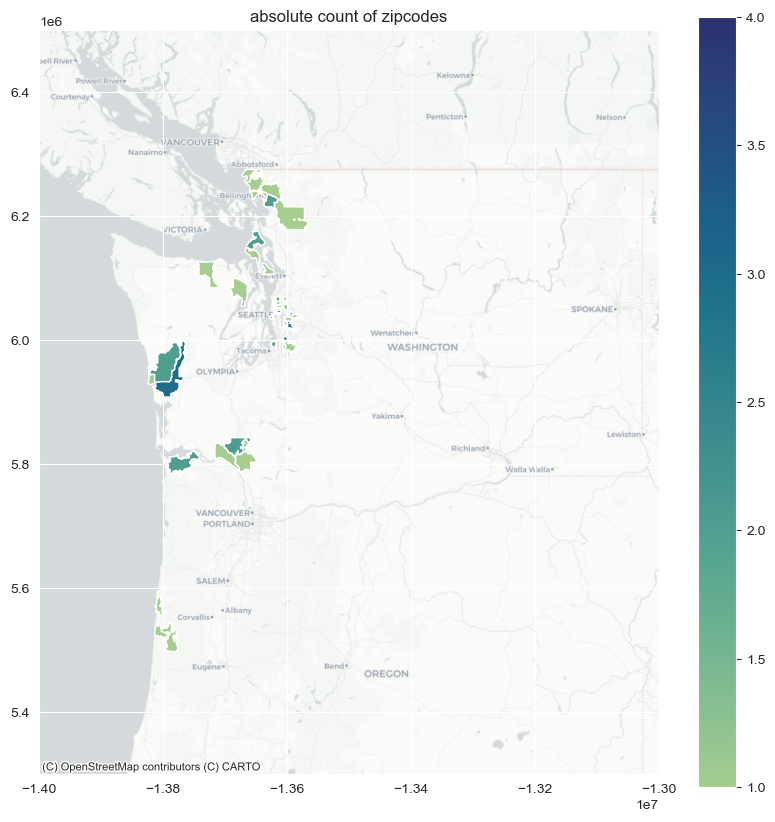

In [46]:
# seattle
bounds = (-14000000, 5300000, -13000000, 6500000)

fig, ax = plt.subplots(figsize=(10,10))
zip_gdf.plot(ax=ax, cmap='crest', alpha=1, column='density', legend=True)
ax.set_xlim(bounds[0], bounds[2])  # Longitude limits
ax.set_ylim(bounds[1], bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title('absolute count of zipcodes')
plt.savefig('figures/density/seattle_zips_density.png')

<span style='color:lightgreen'>
Findings:

- highest count of repsonses in one zipcode is 5

- overall, response rate spread very thin across space, very evenly

- most responses are in florida (see above too) but are evenly dispersed in space  

- spatial interaction might be hard to fetch with such low data density
- LISA plots / spatial autocorrelation not making sense anymore?

<span style='color:orange'>
Let's saerch for seperating equilibria next 

In [47]:
# Let's look at insurance take up

# are the insurance take up maps below computed correctly? how can we double check? 

''''gdf_agg = florida.groupby('zipcode', as_index=False)['insured'].mean()

copy = florida.copy()
zip_geometry = copy.drop_duplicates('zipcode')[['zipcode','geometry']]
gdf_plot = zip_geometry.merge(gdf_agg, on='zipcode')

gdf_plot.plot(
    column='insured',
    cmap='Blues',
    legend=True,
    scheme='Quantiles',
    k=5
)'''

"'gdf_agg = florida.groupby('zipcode', as_index=False)['insured'].mean()\n\ncopy = florida.copy()\nzip_geometry = copy.drop_duplicates('zipcode')[['zipcode','geometry']]\ngdf_plot = zip_geometry.merge(gdf_agg, on='zipcode')\n\ngdf_plot.plot(\n    column='insured',\n    cmap='Blues',\n    legend=True,\n    scheme='Quantiles',\n    k=5\n)"

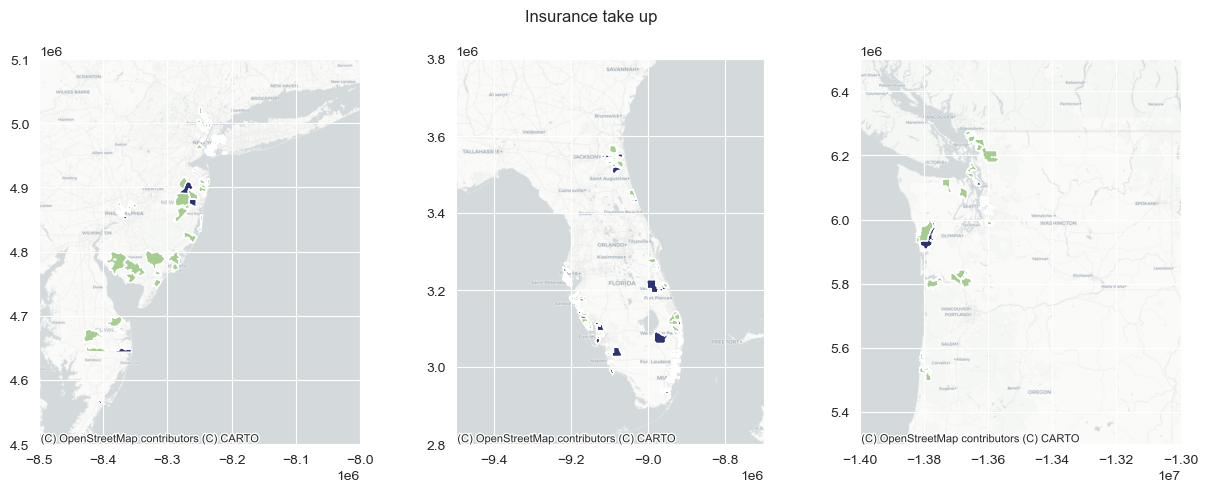

In [48]:
# let's plot insurance takeup

bounds = [(-8500000, 4500000, -8000000, 5100000),       #new jersey
          (-9500000, 2800000,  -8700000, 3800000),      #florida
          (-14000000, 5300000, -13000000, 6500000)]     #seattle

fig, ax = plt.subplots(1,3, figsize=(15,5))

for idx, var in enumerate(bounds):    
    gdf.plot(ax=ax[idx], cmap='crest', column='insured', categorical=True)
    ax[idx].set_xlim(bounds[idx][0], bounds[idx][2])
    ax[idx].set_ylim(bounds[idx][1], bounds[idx][3])
    cx.add_basemap(ax[idx], source=cx.providers.CartoDB.Positron)

plt.suptitle('Insurance take up')
plt.savefig('figures/density/insurance.png')

<span style='color:lightgreen'>
findings: 

- insurance take up is much more pronounced in florida, compared to seattle and new jersey

- first hint at pooling equilibrium 

- lets see if there are counfounding factors? 

<span>

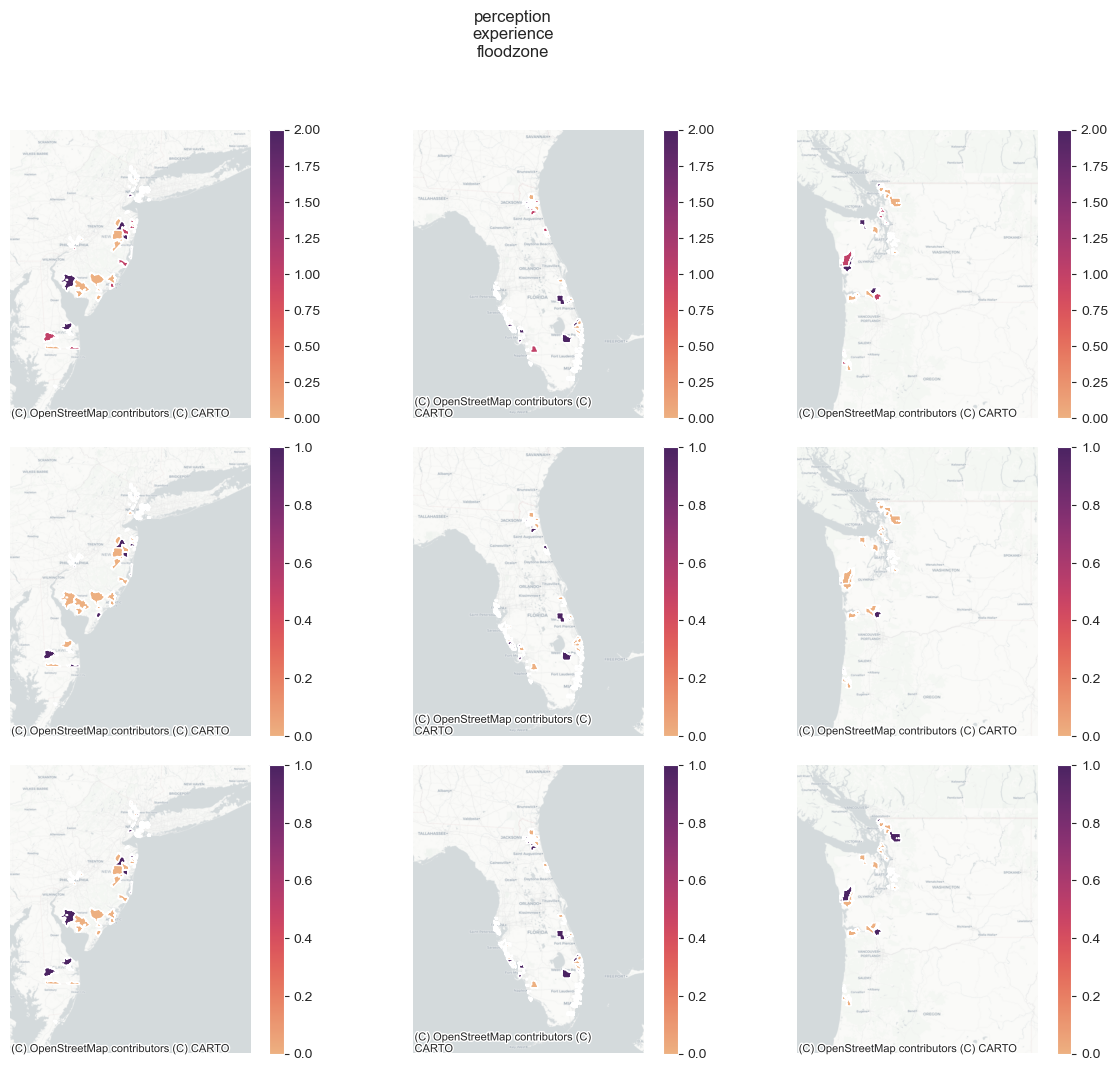

In [49]:
bounds = [(-8500000, 4500000, -8000000, 5100000),       #new jersey
          (-9500000, 2800000,  -8700000, 3800000),      #florida
          (-14000000, 5300000, -13000000, 6500000)]     #seattle

variables = ['perception', 'experience', 'floodzone']

fig, ax = plt.subplots(3,3, figsize=(15,12))

for i, variable in enumerate(variables):
    for idx, var in enumerate(bounds):    
        gdf.plot(ax=ax[i,idx], cmap='flare', column=variable, legend=True)
        ax[i,idx].set_xlim(bounds[idx][0], bounds[idx][2])
        ax[i,idx].set_ylim(bounds[idx][1], bounds[idx][3])
        ax[i,idx].set_axis_off()
        cx.add_basemap(ax[i,idx], source=cx.providers.CartoDB.Positron)

plt.subplots_adjust(wspace=0.05, hspace=0.1) # manually control spacing 
plt.suptitle("perception\nexperience\nfloodzone")
plt.savefig('figures/density/perception.png')

<span style = 'color:lightgreen'>
findings: 

- experience seems to correlate with insurance take up 

- when you know that you are in a flood zone, you are more likely linsured in new jersey and florida, but not in seattle! 

- in seattle people are having higher perception but no experience -> no insurance take up

- in florida we have high perception, high experience, and high take up

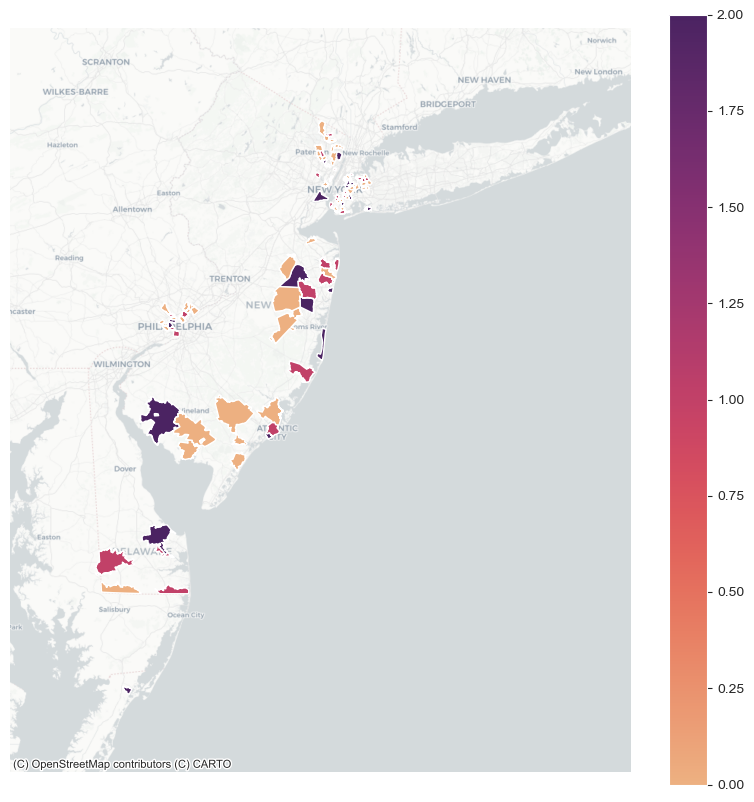

In [50]:
# let's do single line to ensure higher resolution 

bounds = (-8500000, 4500000, -8000000, 5100000) #new jersey 
fig, ax = plt.subplots(figsize=(10,10))   
gdf.plot(ax=ax, cmap='flare', column='perception', legend=True)
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.savefig('figures/density/perception_newjersey.png')

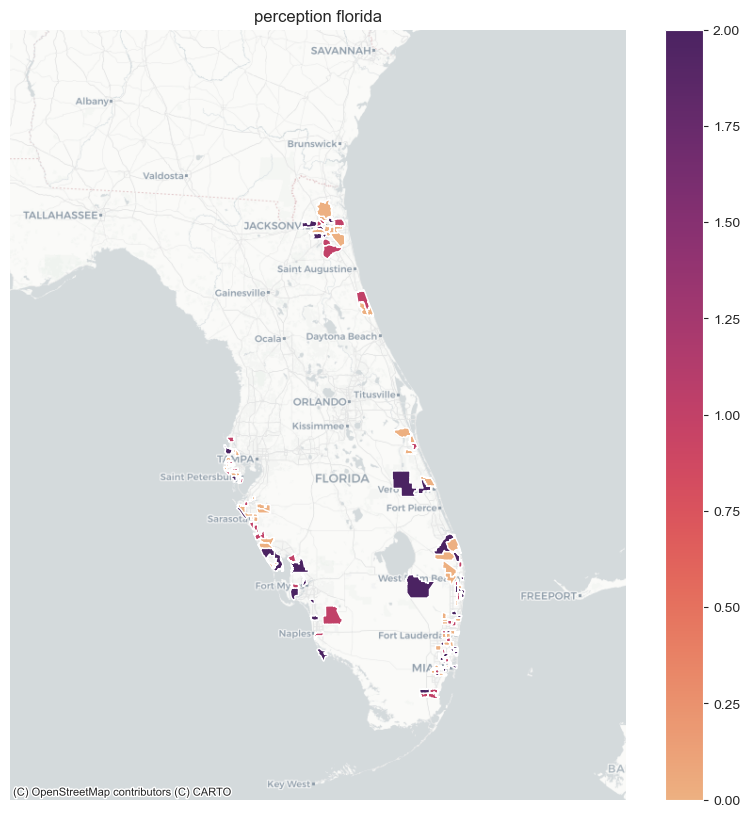

In [51]:
# let do them single (bigger)
bounds = (-9500000, 2800000,  -8700000, 3800000) #florida

fig, ax = plt.subplots(figsize=(10,10))   
gdf.plot(ax=ax, cmap='flare', column='perception', legend=True)
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title('perception florida')
plt.savefig('figures/density/perception_florida.png')

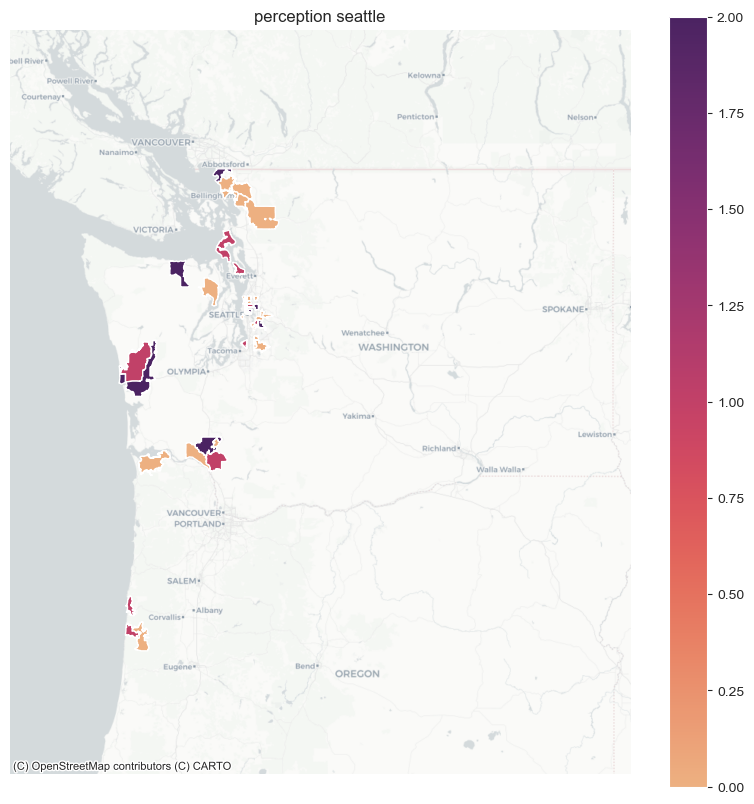

In [52]:
bounds = (-14000000, 5300000, -13000000, 6500000) # seattle

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, cmap='flare', column='perception', legend=True)
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_axis_off()
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron)
plt.title('perception seattle')
plt.savefig('figures/density/perception_seattle.png')


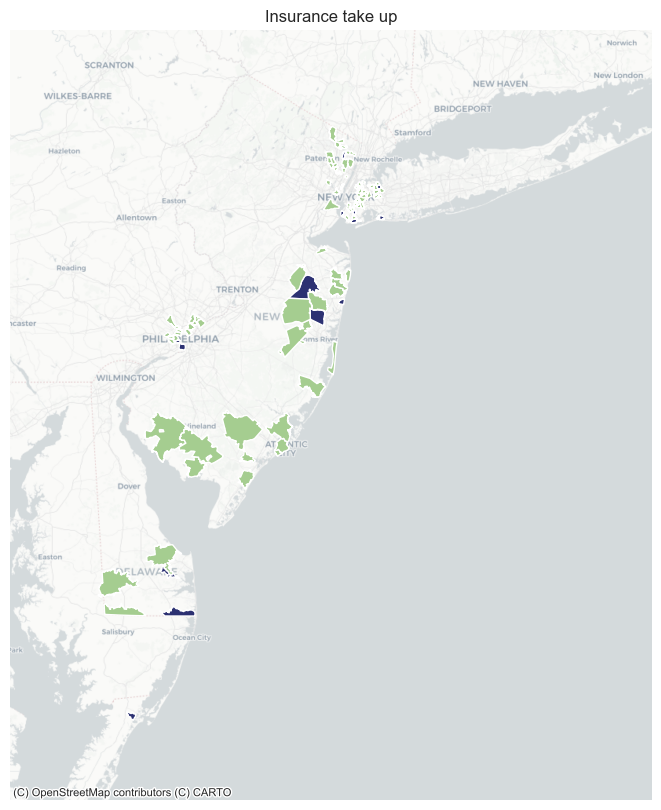

In [53]:
# now for insurance
bounds = (-8500000, 4500000, -8000000, 5100000) #new jersey

fig, ax = plt.subplots(figsize=(10,10))

gdf.plot(ax=ax, cmap='crest', column='insured')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title('Insurance take up')
plt.savefig('figures/density/insurance_newjersey.png')

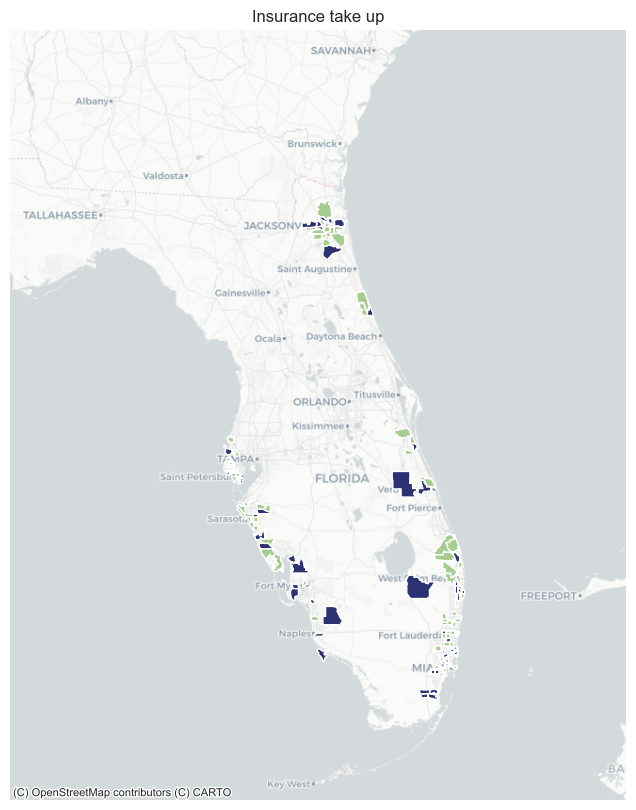

In [54]:
# now for insurance
bounds = (-9500000, 2800000,  -8700000, 3800000) #florida

fig, ax = plt.subplots(figsize=(10,10))

gdf.plot(ax=ax, cmap='crest', column='insured')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title('Insurance take up')
plt.savefig('figures/density/insurance_florida.png')

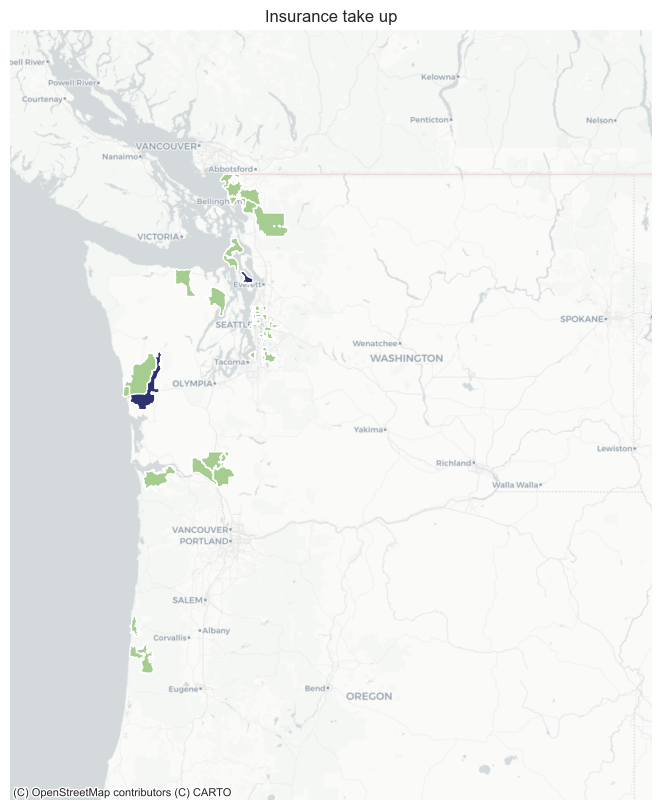

In [55]:
# now for insurance
bounds = (-14000000, 5300000, -13000000, 6500000) # seattle

fig, ax = plt.subplots(figsize=(10,10))

gdf.plot(ax=ax, cmap='crest', column='insured')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title('Insurance take up')
plt.savefig('figures/density/insurance_seattle.png')

<span style = 'color:orange'> Let's have a look at counties

In [ ]:
bounds = (-14000000, 5300000, -13000000, 6500000) # seattle

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, cmap='flare', column='perception', legend=True)
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_axis_off()
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron)
plt.title('perception seattle')

In [ ]:
# now for insurance
bounds = (-8500000, 4500000, -8000000, 5100000) #new jersey

fig, ax = plt.subplots(figsize=(10,10))

gdf.plot(ax=ax, cmap='crest', column='insured')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title('Insurance take up')

In [ ]:
# now for insurance
bounds = (-9500000, 2800000,  -8700000, 3800000) #florida

fig, ax = plt.subplots(figsize=(10,10))

gdf.plot(ax=ax, cmap='crest', column='insured')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title('Insurance take up')

In [ ]:
# now for insurance
bounds = (-14000000, 5300000, -13000000, 6500000) # seattle

fig, ax = plt.subplots(figsize=(10,10))

gdf.plot(ax=ax, cmap='crest', column='insured')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title('Insurance take up')

#### <span style = 'color:orange'> Let's drill down into adaptation measures per state and zipcode <span>

In [56]:
adaptations = gdf.groupby('state').agg(
    supplies = ('supplies','sum'),
    insurance = ('insured','sum'),
    involved = ('involved','sum'),
    learned_routes = ('learned_routes','sum'),
    made_plan =  ('made_plan', 'sum'),
    made_safer = ('made_safer', 'sum'),
    planned_neighbors = ('planned_neighbors', 'sum'),
    practiced_drills = ('practiced_drills', 'sum'),
    documents = ('documents', 'sum'),
    rainy_day = ('rainy_day', 'sum'),
    alerts = ('alerts', 'sum'),
    family_communication = ('family_communication', 'sum'),
    none = ('none', 'sum'),
    dont_know = ('dont_know', 'sum')
    ).transpose()

In [62]:
adaptations[['Washington', 'Florida', 'New York', 'New Jersey', 'Delaware']]

state                 Washington  Florida  New York  New Jersey  Delaware
supplies                      14       48        10          11         2
insurance                      9       60         9           5         2
involved                       7       17         9           4         1
learned_routes                 9       59         9           9         3
made_plan                      9       46        13           9         3
made_safer                     6       49         7           6         2
planned_neighbors              8       24         5           3         0
practiced_drills               6       18         4           1         2
documents                      7       45         8           8         2
rainy_day                      7       37         7          11         4
alerts                         7       48         8           5         2
family_communication           4       27         5           5         2
none                          33       63        22          31         2
dont_know                      2        4         1           4         0

<Axes: title={'center': 'share of adaptations implemented per state'}>

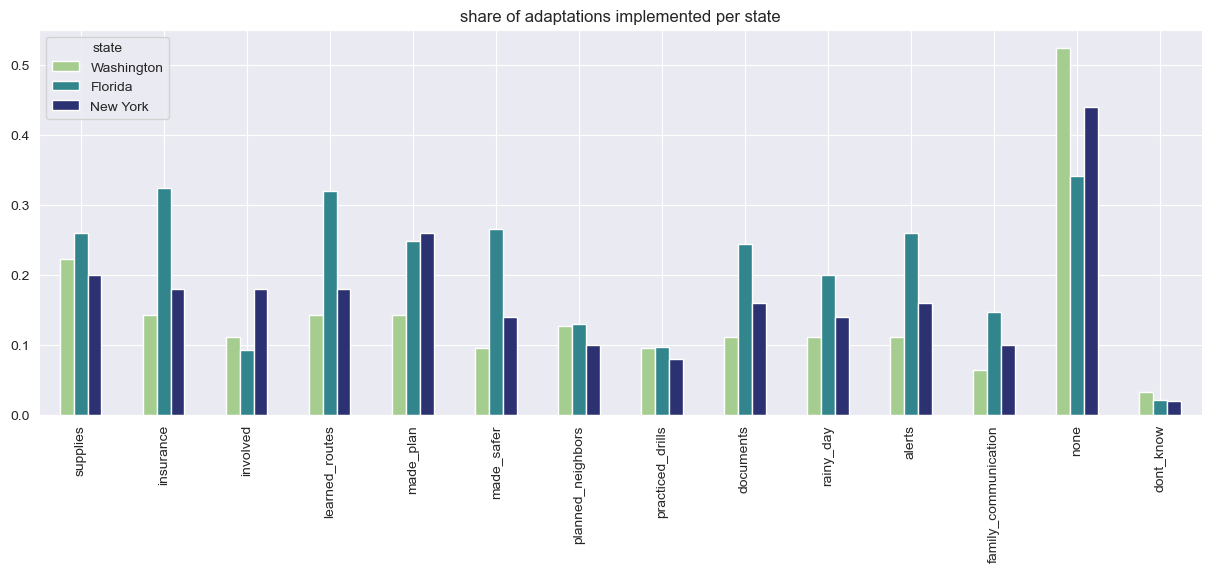

In [ ]:
adaptations[['Washington', 'Florida', 'New York']].plot(
    kind='bar', 
    figsize=(15,5), 
    title='share of adaptations implemented per state',
    cmap='crest')

<span style = 'color:lightgreen'>
findings: 

- numbers might still be a bit skewed: FLorida and Washington are dispersed spatially more than New York

- Florida has generally higher share of adaptations implemented -> seperating equilibrium? 

In [58]:
gdf.groupby('state')['zipcode'].count()

state
Delaware            6
Florida           185
Louisiana          10
New Jersey         64
New York           50
Oregon              5
Pennsylvania       20
South Carolina      1
Texas               4
Virginia            1
Washington         63
Name: zipcode, dtype: int64

<span style = 'color:lightgreen'>
suitable focus groups: FLorida, New York, Washington

In [ ]:
# Let's drill down zipcodes in FLorida and Washington 


In [ ]:
#Let's drill into zipcode level adaptation distribution per focus region 
florida_adaptations = gdf.groupby('zipcode').agg(
    supplies = ('supplies','sum'),
    insurance = ('insured','sum'),
    involved = ('involved','sum'),
    learned_routes = ('learned_routes','sum'),
    made_plan =  ('made_plan', 'sum'),
    made_safer = ('made_safer', 'sum'),
    planned_neighbors = ('planned_neighbors', 'sum'),
    practiced_drills = ('practiced_drills', 'sum'),
    documents = ('documents', 'sum'),
    rainy_day = ('rainy_day', 'sum'),
    alerts = ('alerts', 'sum'),
    family_communication = ('family_communication', 'sum'),
    none = ('none', 'sum'),
    dont_know = ('dont_know', 'sum')
)

<Axes: ylabel='zipcode'>

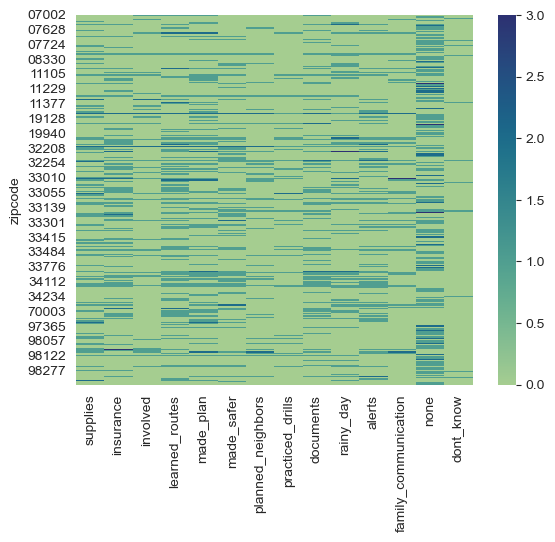

In [ ]:
newjersey_adaptations = gdf.groupby('zipcode').agg(
    supplies = ('supplies','sum'),
    insurance = ('insured','sum'),
    involved = ('involved','sum'),
    learned_routes = ('learned_routes','sum'),
    made_plan =  ('made_plan', 'sum'),
    made_safer = ('made_safer', 'sum'),
    planned_neighbors = ('planned_neighbors', 'sum'),
    practiced_drills = ('practiced_drills', 'sum'),
    documents = ('documents', 'sum'),
    rainy_day = ('rainy_day', 'sum'),
    alerts = ('alerts', 'sum'),
    family_communication = ('family_communication', 'sum'),
    none = ('none', 'sum'),
    dont_know = ('dont_know', 'sum')
)

In [73]:
sub_df.zipcode.to_csv('zipcodes.csv')

<span style = 'color:orange'>

Fuck it let's go for the logits

In [ ]:
model = smf.logit("insured ~ experience + rentmortgage + income", data=gdf).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.495918
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                insured   No. Observations:                  507
Model:                          Logit   Df Residuals:                      503
Method:                           MLE   Df Model:                            3
Date:                Wed, 12 Feb 2025   Pseudo R-squ.:                 0.01749
Time:                        09:36:12   Log-Likelihood:                -251.43
converged:                       True   LL-Null:                       -255.91
Covariance Type:            nonrobust   LLR p-value:                   0.02994
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.8376      0.236     -7.782      0.000      -2.300      -1.375
experience       0.4516

In [ ]:
model_florida = smf.logit("insured ~ experience + rentmortgage + income", data=florida).fit()
model_newjersey = smf.logit("insured ~ experience + rentmortgage + income", data=newjersey).fit()
model_seattle = smf.logit("insured ~ experience + rentmortgage + income", data=seattle).fit()


Optimization terminated successfully.
         Current function value: 0.602571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.359619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.294941
         Iterations 7


In [ ]:
print(model_florida.summary())
print(model_newjersey.summary())
print(model_seattle.summary())

                           Logit Regression Results                           
Dep. Variable:                insured   No. Observations:                  245
Model:                          Logit   Df Residuals:                      241
Method:                           MLE   Df Model:                            3
Date:                Wed, 12 Feb 2025   Pseudo R-squ.:                0.004981
Time:                        09:36:12   Log-Likelihood:                -147.63
converged:                       True   LL-Null:                       -148.37
Covariance Type:            nonrobust   LLR p-value:                    0.6873
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.1582      0.286     -4.049      0.000      -1.719      -0.598
experience       0.1537      0.243      0.632      0.527      -0.323       0.630
rentmortgage  5.886e-05      0.000      0.35

In [ ]:
florida.income.mean()

63173.4693877551

In [ ]:
seattle.income.mean()

61744.186046511626

In [ ]:
newjersey.income.mean()

72698.86363636363

In [ ]:
gdf.income.mean()

66237.67258382642